
# USGS: Loading data
Data retrieved from https://www.waterqualitydata.us/, filtering on lakes & streams data with the nutrient of phosphorus

In [1]:
import pandas as pd
import numpy as np
import geopy
import geopandas
import csv, json
from geojson import Feature, FeatureCollection, Point

data = pd.read_csv('data/usgs_phos.csv', low_memory=False)

In [2]:
data

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityTypeCode,ActivityMediaName,ActivityMediaSubdivisionName,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,ActivityEndDate,...,LaboratoryName,AnalysisStartDate,ResultLaboratoryCommentText,ResultDetectionQuantitationLimitUrl,DetectionQuantitationLimitTypeName,DetectionQuantitationLimitMeasure/MeasureValue,DetectionQuantitationLimitMeasure/MeasureUnitCode,LabSamplePreparationUrl,LastUpdated,ProviderName
0,USGS-PR,USGS Puerto Rico Water Science Center,nwispr.01.01100060,Sample-Routine,Water,Surface Water,2010-10-19,13:15:00,AST,NaN,...,"USGS-National Water Quality Lab, Denver, CO",2010-11-09,sample was diluted,NaN,Long Term Method Detection Level,0.004,mg/l as P,NaN,NaN,NWIS
1,USGS-PA,USGS Pennsylvania Water Science Center,nwispa.01.01100328,Sample-Routine,Water,Surface Water,2010-11-02,12:00:00,EDT,NaN,...,Pennsylvania Department of Environmental Prote...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
2,USGS-OR,USGS Oregon Water Science Center,nwisor.01.01001795,Sample-Routine,Water,Surface Water,2010-06-01,09:11:00,PDT,NaN,...,"Clean Water Services, Hillsboro, OR",NaN,NaN,NaN,Lower Reporting Limit,0.025,mg/l as P,NaN,NaN,NWIS
3,USGS-WI,USGS Wisconsin Water Science Center,nwiswi.01.01004665,Sample-Routine,Water,Surface Water,2010-03-17,12:00:00,CDT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
4,USGS-MS,USGS Mississippi Water Science Center,nwisms.01.01100120,Sample-Routine,Water,Surface Water,2010-11-26,00:00:00,CST,NaN,...,"Office of Pollution Control, Mississippi",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1758476,21VASWCB,VIRGINIA DEPARTMENT OF ENVIRONMENTAL QUALITY,21VASWCB-3121778.3,Quality Control Sample-Field Replicate,Water,Surface Water,2024-02-12,09:45:00,EST,2024-02-12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-02-26T11:00:24,STORET
1758477,21VASWCB,VIRGINIA DEPARTMENT OF ENVIRONMENTAL QUALITY,21VASWCB-3120026.3,Sample-Routine,Water,Surface Water,2024-01-10,13:20:00,EST,2024-01-10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-02-12T10:39:17,STORET
1758478,21VASWCB,VIRGINIA DEPARTMENT OF ENVIRONMENTAL QUALITY,21VASWCB-3120677.2,Sample-Routine,Water,Surface Water,2024-01-22,12:00:00,EST,2024-01-22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-02-19T09:50:13,STORET
1758479,ESTO_WQX,Eastern Shawnee Tribe of Oklahoma,ESTO_WQX-LC201302024S,Sample-Routine,Water,NaN,2024-01-30,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-02-12T16:30:44,STORET


# USGS Data: Shaping

In [2]:
# creating a new dataframe that is condensed and only containing the fields we need, starting with 1758481 rows

data_condensed = data[['OrganizationIdentifier','ActivityMediaSubdivisionName','ActivityStartDate','ResultMeasureValue','ResultMeasure/MeasureUnitCode','ActivityLocation/LatitudeMeasure','ActivityLocation/LongitudeMeasure','HydrologicEvent']].copy()
len(data_condensed)

1758481

In [3]:
# if there is an NaN in any field besides HydrologicEvent or ActivityMediaSubdivisionName, drop the row. ending with 630448 rows

data_condensed.dropna(subset=['OrganizationIdentifier','ActivityStartDate','ResultMeasureValue','ResultMeasure/MeasureUnitCode','ActivityLocation/LatitudeMeasure','ActivityLocation/LongitudeMeasure'],inplace=True)
data_condensed.shape #1304819

(1304819, 8)

In [4]:
# convert the ResultMeasureValue field to numeric, coerce errors so that the values that look like "<0.05" show up as 0

data_condensed['ResultMeasureValue'] = pd.to_numeric(data_condensed['ResultMeasureValue'], errors='coerce')
data_condensed['ResultMeasureValue'] = data_condensed['ResultMeasureValue'].fillna(0)

# USGS Data: Mitigating Unit Measure Issues

In [5]:
# dealing with differing units

# mg (milligrams) per liter = mg per 1,000cc and 1000 cc of water weighs 1 kg. Therefore, 1 mg/L is the same as 1 mg/kg if you are talking about water. (ResearchGate, https://www.researchgate.net/post/Converting_mg_l_to_mg_kg#:~:text=mg%20(milligrams)%20per%20liter%20%3D,you%20are%20talking%20about%20water.)

# conversion for ppb and ppm to mg/L chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://cfpub.epa.gov/ncer_abstracts/index.cfm/fuseaction/display.files/fileid/14285

# convert ug/L to mg/L --> divide by 1000
# convert ppb to mg/L --> divide by 1000
# convert ppm to mg/L --> just change units
# convert mg/kg to mg/L --> divide by 1000

data_condensed['ResultMeasure/MeasureUnitCode'].unique()
data_condensed['ResultMeasure/MeasureUnitCode'].value_counts()

ResultMeasure/MeasureUnitCode
mg/L         1162932
ug/L          128348
ppm             8611
ppb             3979
mg/kg            634
ug               158
%                144
count              6
mL/L               4
MPN/100mL          2
#/100mL            1
Name: count, dtype: int64

In [6]:
### --- investigation 'ug' only --- ###

# 0.325 to about 1.6, surface water for the 'ug'
# looks like this UG code is in OrganizationIdentifier called "21VASWCB", which is the VIRGINIA DEPARTMENT OF ENVIRONMENTAL QUALITY. confirmed via value_counts that this is the only org using 'ug'
ug = data_condensed.loc[data_condensed['ResultMeasure/MeasureUnitCode'] == 'ug']
ug['OrganizationIdentifier'].value_counts() #158
ug['ResultMeasureValue'].max() #1.62
ug['ResultMeasureValue'].min() #0.325

0.325

In [7]:
# how comparable are ug and ug/L? are they of the same scale? we can treat these differently
ugL = data_condensed.loc[data_condensed['ResultMeasure/MeasureUnitCode'] == 'ug/L']
# ugL['ResultMeasureValue'].max() #2971.9
# ugL['ResultMeasureValue'].min() #-0.948print(ugL.iloc[2])

In [8]:
# looking at one specific row, 2, current value is 1.234
print(ugL.iloc[2])

OrganizationIdentifier                 1VTDECWQ
ActivityMediaSubdivisionName                NaN
ActivityStartDate                    2010-08-19
ResultMeasureValue                         13.4
ResultMeasure/MeasureUnitCode              ug/L
ActivityLocation/LatitudeMeasure        44.5819
ActivityLocation/LongitudeMeasure      -73.2811
HydrologicEvent                             NaN
Name: 375362, dtype: object


In [9]:
# convertsion, divide all cells by 1000 if ResultMeasureUnit is indicated above else ResultMeasureValue

data_condensed['ResultMeasureValue'] = data_condensed.apply(lambda x: x['ResultMeasureValue']/1000 if x['ResultMeasure/MeasureUnitCode']=='ug/L' else x['ResultMeasureValue'], axis=1)

data_condensed['ResultMeasureValue'] = data_condensed.apply(lambda x: x['ResultMeasureValue']/1000 if x['ResultMeasure/MeasureUnitCode']=='ppb' else x['ResultMeasureValue'], axis=1)

data_condensed['ResultMeasureValue'] = data_condensed.apply(lambda x: x['ResultMeasureValue']/1000 if x['ResultMeasure/MeasureUnitCode']=='mg/kg' else x['ResultMeasureValue'], axis=1)

In [10]:
# confirmed! value was divided by 1000

ugL = data_condensed.loc[data_condensed['ResultMeasure/MeasureUnitCode'] == 'ug/L']
print(ugL.iloc[2])

OrganizationIdentifier                 1VTDECWQ
ActivityMediaSubdivisionName                NaN
ActivityStartDate                    2010-08-19
ResultMeasureValue                       0.0134
ResultMeasure/MeasureUnitCode              ug/L
ActivityLocation/LatitudeMeasure        44.5819
ActivityLocation/LongitudeMeasure      -73.2811
HydrologicEvent                             NaN
Name: 375362, dtype: object


In [11]:
# now fixing units for the values that were changed, from ug/L to mg/L & mg/kg to mg/L

data_condensed['ResultMeasure/MeasureUnitCode'].replace('ug/L','mg/L',inplace=True)
data_condensed['ResultMeasure/MeasureUnitCode'].replace('mg/kg','mg/L',inplace=True)
data_condensed['ResultMeasure/MeasureUnitCode'].replace('ppb','mg/L',inplace=True)
data_condensed['ResultMeasure/MeasureUnitCode'].replace('ppm','mg/L',inplace=True)


C:\Users\caraca\AppData\Local\Temp\1\ipykernel_36176\4114405720.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_condensed['ResultMeasure/MeasureUnitCode'].replace('ug/L','mg/L',inplace=True)
C:\Users\caraca\AppData\Local\Temp\1\ipykernel_36176\4114405720.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting 

In [12]:
# confirming that worked

data_condensed['ResultMeasure/MeasureUnitCode'].value_counts()

ResultMeasure/MeasureUnitCode
mg/L         1304504
ug               158
%                144
count              6
mL/L               4
MPN/100mL          2
#/100mL            1
Name: count, dtype: int64

In [13]:
# include only rows with mg/L; the remaining rows represent an insignificant number of rows
data_condensed = data_condensed[data_condensed['ResultMeasure/MeasureUnitCode'] == 'mg/L']
data_condensed['ResultMeasure/MeasureUnitCode'].value_counts() #1304504

ResultMeasure/MeasureUnitCode
mg/L    1304504
Name: count, dtype: int64

# Removing outliers greater than 40

In [14]:
#TODO add in outlier analysis code

In [15]:

# Keep rows where the value in column 'A' is less than or equal to 40
data_condensed_filtered = data_condensed[data_condensed['ResultMeasureValue'] < 40]

# Using GeoPandas to spatially join larger geographical mappings to lat-long usgs data

In [16]:
#creating a further condensed data set with just the lat and lon points
df2 = pd.DataFrame()
df2['Lat'] = data_condensed_filtered['ActivityLocation/LatitudeMeasure']
df2['Lon'] = data_condensed_filtered['ActivityLocation/LongitudeMeasure']
# note that in this csv, i renamed the fields to 'latitutde', 'longitude', and 'position', copying the index. later, to make the geopandas work, i had to delete the field names
df2.to_csv('latlong.csv', header=False)

In [17]:
# reading the csv, transforming it to geojason (remember i deleted column labels, probably could've just started to read at row 1...
features = []
with open('latlong.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for position, latitude, longitude in reader:
        latitude, longitude = map(float, (latitude, longitude))
        features.append(
            Feature(
                geometry = Point((longitude, latitude)),
                properties = {
                    'position': position,
                }
            )
        )

collection = FeatureCollection(features)
with open("GeoObs.json", "w") as f:
    f.write('%s' % collection)

# Spatially joining for counties

https://hub.arcgis.com/datasets/esri::usa-counties/about

In [18]:
# points = geopandas.read_file('GeoObs.json')
# counties = geopandas.read_file("USA_counties_gdb.gdb")
# county_points = points.sjoin(counties, how='left', )

points = geopandas.read_file('GeoObs.json')
counties = geopandas.read_file("USA_counties_gdb.gdb").to_crs(4326)
county_points = points.sjoin(counties, how='left', )

# Merging DFs Together, Including Only Great Lakes Region

In [19]:
# first change dtype from object to int for position
# zip_points['position']=zip_points['position'].astype(int)
county_points['position']=county_points['position'].astype(int)

In [20]:
# traditional inner join to merge the 2 data frames
# data_usgs = pd.merge(data_condensed,zip_points,left_index=True, right_on='position')
data_usgs = pd.merge(data_condensed,county_points,left_index=True, right_on='position')

In [21]:
# data_usgs.to_csv('data_usgs_counties.csv')

In [22]:
great_lakes_states = ['MI','OH','PA','IL','IN','MN','NY','WI']
great_lakes_state_names = ['Michigan','Ohio','Pennsylvania','Illinois','Indiana','Minnesota','New York', 'Wisconsin']

In [23]:
# data_usgs_GL = data_usgs[data_usgs.STATE.isin(great_lakes_states)]
data_usgs_GL = data_usgs[data_usgs.STATE_NAME.isin(great_lakes_state_names)]


In [24]:
# rename columns, pull out desired, separate out the imputing data frame from the descriptive dataframe... intent to merge back together later on
data_usgs_GL.rename(columns={'NAME': 'CountyName'}, inplace=True)
data_usgs_GL['CountyState'] = data_usgs_GL['CountyName']+'-'+ data_usgs_GL['STATE_NAME']


C:\Users\caraca\AppData\Local\Temp\1\ipykernel_36176\3442111917.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_usgs_GL.rename(columns={'NAME': 'CountyName'}, inplace=True)
C:\Users\caraca\AppData\Local\Temp\1\ipykernel_36176\3442111917.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_usgs_GL['CountyState'] = data_usgs_GL['CountyName']+'-'+ data_usgs_GL['STATE_NAME']


In [25]:
data_usgs_GL['ActivityStartDate'] = pd.to_datetime(data_usgs_GL['ActivityStartDate'])
data_usgs_GL['ActivityYear'] = data_usgs_GL['ActivityStartDate'].dt.year

C:\Users\caraca\AppData\Local\Temp\1\ipykernel_36176\739279451.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_usgs_GL['ActivityStartDate'] = pd.to_datetime(data_usgs_GL['ActivityStartDate'])
C:\Users\caraca\AppData\Local\Temp\1\ipykernel_36176\739279451.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_usgs_GL['ActivityYear'] = data_usgs_GL['ActivityStartDate'].dt.year


In [26]:
data_usgs_GL['CNTY_FIPS'] = data_usgs_GL['CNTY_FIPS'].astype('float64')
data_usgs_GL['STATE_FIPS'] = data_usgs_GL['STATE_FIPS'].astype('float64')

C:\Users\caraca\AppData\Local\Temp\1\ipykernel_36176\1227607867.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_usgs_GL['CNTY_FIPS'] = data_usgs_GL['CNTY_FIPS'].astype('float64')
C:\Users\caraca\AppData\Local\Temp\1\ipykernel_36176\1227607867.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_usgs_GL['STATE_FIPS'] = data_usgs_GL['STATE_FIPS'].astype('float64')


In [27]:
len(data_usgs_GL) #455550
# data_usgs_GL.to_csv('data_usgs_counties_GL0406.csv')

455550

In [28]:
data_usgs_GL

,OrganizationIdentifier,ActivityMediaSubdivisionName,ActivityStartDate,ResultMeasureValue,ResultMeasure/MeasureUnitCode,ActivityLocation/LatitudeMeasure,ActivityLocation/LongitudeMeasure,HydrologicEvent,position,geometry,...,SQMI,NO_FARMS17,AVE_SIZE17,CROP_ACR17,AVE_SALE17,Shape_Leng,SHAPE_Length,SHAPE_Area,CountyState,ActivityYear
2,MNPCA,Surface Water,2010-09-01,0.0610,mg/L,44.926900,-93.362400,NaN,375302,POINT (-93.36240 44.92690),...,606.79,467.0,98.0,36623.0,125418.0,2.043827,269395.417723,0.179370,Hennepin County-Minnesota,2010
5,MNPCA,Surface Water,2010-06-24,0.4540,mg/L,43.513917,-93.268611,NaN,375305,POINT (-93.26861 43.51392),...,722.42,1076.0,366.0,374911.0,338289.0,1.895490,240696.187148,0.208823,Freeborn County-Minnesota,2010
8,MNPCA,Surface Water,2010-08-16,0.0140,mg/L,46.931197,-94.772603,NaN,375308,POINT (-94.77260 46.93120),...,999.49,384.0,246.0,53391.0,115220.0,2.265708,315677.698853,0.306781,Hubbard County-Minnesota,2010
14,MNPCA,Surface Water,2010-09-07,0.3670,mg/L,43.590170,-94.681010,NaN,375315,POINT (-94.68101 43.59017),...,729.58,911.0,493.0,434319.0,697611.0,1.909775,242215.618493,0.210894,Martin County-Minnesota,2010
17,MNPCA,Surface Water,2010-07-27,0.0190,mg/L,45.705203,-94.747231,NaN,375318,POINT (-94.74723 45.70520),...,1390.02,2951.0,221.0,515928.0,253466.0,3.195917,401039.073367,0.414828,Stearns County-Minnesota,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304376,WIDNR_WQX,NaN,2024-01-09,0.0213,mg/L,45.371741,-91.208534,NaN,1758434,POINT (-91.20853 45.37174),...,930.86,501.0,272.0,70661.0,107354.0,2.417757,302007.435056,0.277423,Rusk County-Wisconsin,2024
1304378,HO_CHUNK_WQX,NaN,2024-01-04,0.0340,mg/L,44.037100,-89.722700,NaN,1758436,POINT (-89.72270 44.03710),...,687.48,308.0,381.0,84544.0,425646.0,2.125677,286964.278008,0.199696,Adams County-Wisconsin,2024
1304386,WIDNR_WQX,NaN,2024-01-12,0.0409,mg/L,43.650870,-89.612390,NaN,1758444,POINT (-89.61239 43.65087),...,687.48,308.0,381.0,84544.0,425646.0,2.125677,286964.278008,0.199696,Adams County-Wisconsin,2024
1304389,WIDNR_WQX,NaN,2024-01-29,0.0226,mg/L,43.953910,-88.952560,NaN,1758447,POINT (-88.95256 43.95391),...,380.13,502.0,252.0,99674.0,180513.0,1.497150,197190.068599,0.110108,Green Lake County-Wisconsin,2024


# Analysis on dataset

In [29]:
stats_by_state = data_usgs_GL.groupby('STATE_NAME')['ResultMeasureValue'].agg(['count','mean', 'median', 'std', 'var', 'min', 'max'])

# Gini data, filtering on 2017

In [71]:
gini = pd.read_csv('data/giniusgs_fips.csv')
gini['fips'] = gini['fips'].astype(str)

In [61]:
gini

,state_fips,county_fips,year,poverty_count_in_last12month,gini_index,fips
0,NaN,NaN,2010,NaN,NaN,nan
1,NaN,NaN,2010,NaN,NaN,nan
2,NaN,NaN,2010,NaN,NaN,nan
3,NaN,NaN,2010,NaN,NaN,nan
4,NaN,NaN,2010,NaN,NaN,nan
...,...,...,...,...,...,...
455561,NaN,NaN,2024,NaN,NaN,nan
455562,NaN,NaN,2024,NaN,NaN,nan
455563,NaN,NaN,2024,NaN,NaN,nan
455564,NaN,NaN,2024,NaN,NaN,nan


In [72]:
gini_2017 = gini.drop_duplicates()
gini_2017 = gini_2017[gini_2017['year'] == 2017]

In [75]:
gini_2017['fips'] = gini_2017['fips'].astype(float)
gini_2017['fips'] = gini_2017['fips'].astype(int)
gini_2017['fips'] = gini_2017['fips'].astype(str)

In [76]:
gini_2017.dtypes

state_fips                      float64
county_fips                     float64
year                              int64
poverty_count_in_last12month    float64
gini_index                      float64
fips                             object
dtype: object

In [77]:
gini_2017

,state_fips,county_fips,year,poverty_count_in_last12month,gini_index,fips
270219,42.0,79.0,2017,46537.0,0.4474,42079
270220,27.0,21.0,2017,4339.0,0.4295,27021
270221,17.0,59.0,2017,862.0,0.4362,17059
270222,27.0,117.0,2017,1069.0,0.4723,27117
270223,27.0,7.0,2017,8203.0,0.4463,27007
...,...,...,...,...,...,...
288609,26.0,123.0,2017,8405.0,0.4335,26123
288617,26.0,125.0,2017,111071.0,0.4681,26125
292567,36.0,15.0,2017,12934.0,0.4500,36015
298062,36.0,23.0,2017,6573.0,0.4334,36023


# Dealing with funding data, filtering
https://www.usaspending.gov/search/

In [97]:
data2 = pd.read_csv('funding_awards_payments.csv',low_memory=False)
data2['prime_award_summary_recipient_county_fips_code'] = data2['prime_award_summary_recipient_county_fips_code'].astype(str)

In [98]:
#filtering data to only include EPA and DoA
# agency_list = [12,68]
agency_list = [68]
data2 = data2[data2['awarding_agency_code'].isin(agency_list)]

In [99]:
funding = data2[['award_base_action_date_fiscal_year','awarding_agency_name','awarding_agency_code','total_funding_amount', 'prime_award_summary_place_of_performance_state_fips_code','prime_award_summary_recipient_county_fips_code','primary_place_of_performance_scope']].copy()
len(funding) #2014

1073

In [100]:
funding['county_funding'] = 0
funding['state_funding'] = 0


In [101]:
# if the data indicates that it is county level funding, then assign that amount to a new column called "county funding"

# funding_ny['county_funding'] = funding_ny.loc[funding_ny['primary_place_of_performance_scope'].str.contains('county',case=False, na=False),'total_funding_amount']
# df.loc[df['ColumnA'].notna() & (df['ColumnA'] != ''), 'ColumnC'] = df['ColumnB']
funding.loc[funding['prime_award_summary_recipient_county_fips_code'].notna() & (funding['prime_award_summary_recipient_county_fips_code'] != ''),'county_funding'] = funding['total_funding_amount']

In [102]:
# if the data indicates that it is state/multi-state level funding, then assign that amount to a new column called "state_funding"
funding['state_funding'] = funding.loc[funding['prime_award_summary_recipient_county_fips_code'].isna() | (funding['prime_award_summary_recipient_county_fips_code'] == ''), 'total_funding_amount']

In [103]:
# adding up state and local funding
funding[['county_funding', 'state_funding']] = funding[['county_funding', 'state_funding']].fillna(0)
funding['total_county_state'] = funding['county_funding']+funding['state_funding']


In [104]:
funding_condensed = funding[['award_base_action_date_fiscal_year','prime_award_summary_recipient_county_fips_code','county_funding','state_funding','total_county_state']]

In [105]:
# grouping by fips code per state
funding_grouped = funding_condensed.groupby(['award_base_action_date_fiscal_year','prime_award_summary_recipient_county_fips_code']).sum().reset_index()

In [42]:
funding_grouped.dtypes

award_base_action_date_fiscal_year                  int64
prime_award_summary_recipient_county_fips_code     object
county_funding                                    float64
state_funding                                     float64
total_county_state                                float64
dtype: object

In [43]:
funding_grouped['state_funding'].isna().sum()

0

# Filtering the data for certain year only, only certain awarding organizations

In [179]:
#filtering the data to include only the year 2017

data_usgs_GL_2017 = data_usgs_GL[data_usgs_GL['ActivityYear'] == 2017]
funding_2017 = funding_grouped[funding_grouped['award_base_action_date_fiscal_year'] == 2017]

# Joining funding data, gini data, usgsGL data

In [180]:
usgsginiGL = pd.merge(data_usgs_GL_2017,gini_2017, left_on=['FIPS'], right_on=['fips'], how='left')

In [79]:
len(usgsginiGL)

31297

In [91]:
usgsginiGL

,OrganizationIdentifier,ActivityMediaSubdivisionName,ActivityStartDate,ResultMeasureValue,ResultMeasure/MeasureUnitCode,ActivityLocation/LatitudeMeasure,ActivityLocation/LongitudeMeasure,HydrologicEvent,position,geometry,...,SHAPE_Length,SHAPE_Area,CountyState,ActivityYear,state_fips,county_fips,year,poverty_count_in_last12month,gini_index,fips
0,IL_EPA_WQX,NaN,2019-10-16,0.076,mg/L,38.824300,-89.974400,NaN,1301017,POINT (-89.97440 38.82430),...,254053.440006,0.198836,Madison County-Illinois,2019,17.0,119.0,2017.0,35099.0,0.4452,17119
1,MNPCA,Surface Water,2019-09-23,0.019,mg/L,44.941000,-93.458400,NaN,1301020,POINT (-93.45840 44.94100),...,269395.417723,0.179370,Hennepin County-Minnesota,2019,27.0,53.0,2017.0,138478.0,0.4853,27053
2,MNPCA,Surface Water,2019-07-01,0.255,mg/L,44.283728,-94.076347,NaN,1301026,POINT (-94.07635 44.28373),...,345510.686954,0.136498,Nicollet County-Minnesota,2019,27.0,103.0,2017.0,3514.0,0.4146,27103
3,21PA_WQX,NaN,2019-03-20,0.006,mg/L,41.765300,-76.438600,NaN,1301029,POINT (-76.43860 41.76530),...,298369.662656,0.325712,Bradford County-Pennsylvania,2019,42.0,15.0,2017.0,7430.0,0.4348,42015
4,MNPCA,Surface Water,2019-06-27,0.540,mg/L,45.100198,-94.696072,NaN,1301034,POINT (-94.69607 45.10020),...,250011.106093,0.190942,Meeker County-Minnesota,2019,27.0,93.0,2017.0,1885.0,0.4136,27093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33215,MNPCA,Surface Water,2019-07-29,0.015,mg/L,47.739831,-90.591149,NaN,1425527,POINT (-90.59115 47.73983),...,636849.612451,0.500323,Cook County-Minnesota,2019,27.0,31.0,2017.0,679.0,0.4355,27031
33216,21PA_WQX,NaN,2019-11-05,0.056,mg/L,40.608900,-78.136100,NaN,1425533,POINT (-78.13610 40.60890),...,359595.585107,0.244386,Huntingdon County-Pennsylvania,2019,42.0,61.0,2017.0,5517.0,0.4079,42061
33217,IL_EPA_WQX,NaN,2019-05-13,0.072,mg/L,37.258000,-89.265000,NaN,1425542,POINT (-89.26500 37.25800),...,225132.442225,0.066402,Alexander County-Illinois,2019,17.0,3.0,2017.0,2212.0,0.4750,17003
33218,LEECHLAK_WQX,NaN,2019-08-05,0.017,mg/L,47.224377,-94.672623,NaN,1425543,POINT (-94.67262 47.22438),...,315677.698853,0.306781,Hubbard County-Minnesota,2019,27.0,57.0,2017.0,2216.0,0.4150,27057


In [181]:
data_combined_2017 = pd.merge(usgsginiGL,funding_2017, left_on=['FIPS'], right_on=['prime_award_summary_recipient_county_fips_code'], how='left')

# Grouping the data in preparation for correlation matrix

In [182]:
grouped = data_combined_2017.groupby(['STATE_NAME', 'CountyName']).agg({
    'ResultMeasureValue': 'mean',
    'CROP_ACR17': 'mean',
    'NO_FARMS17': 'mean',
    'AVE_SALE17': 'mean',
    'AVE_SIZE17': 'mean',
    'POPULATION': 'mean',
    'POP_SQMI': 'mean',
    'county_funding': 'mean',
    'state_funding': 'mean',
    'total_county_state': 'mean',
    'poverty_count_in_last12month' : 'mean',
       'gini_index': 'mean'
            })

In [94]:
grouped

ResultMeasureValue  CROP_ACR17  NO_FARMS17  \
STATE_NAME CountyName                                                     
Illinois   Adams County                0.240038    382809.0      1308.0   
           Alexander County            0.153776     43073.0       126.0   
           Boone County                0.070000    106043.0       457.0   
           Bureau County               0.098057    408184.0      1038.0   
           Calhoun County              0.225062     68694.0       474.0   
...                                         ...         ...         ...   
Wisconsin  Waukesha County             0.036220     71502.0       574.0   
           Waupaca County              0.081400    142570.0      1031.0   
           Waushara County             0.116000    100239.0       633.0   
           Winnebago County            0.107433    136192.0       957.0   
           Wood County                 0.195050    128114.0      1062.0   

                             AVE_SALE17  AVE_SIZE17  POPULATION  POP_SQMI  \
STATE_NAME CountyName                                                       
Illinois   Adams County        205979.0       365.0     66092.0      75.9   
           Alexander County    131891.0       401.0      6857.0      27.1   
           Boone County        171588.0       248.0     54613.0     193.6   
           Bureau County       346794.0       421.0     34054.0      39.0   
           Calhoun County       81584.0       242.0      4915.0      17.3   
...                                 ...         ...         ...       ...   
Wisconsin  Waukesha County      88945.0       170.0    411705.0     709.2   
           Waupaca County      147515.0       196.0     51952.0      67.9   
           Waushara County     200162.0       214.0     24648.0      38.7   
           Winnebago County    127710.0       169.0    173572.0     300.0   
           Wood County         132857.0       208.0     74976.0      92.6   

                             county_funding  state_funding  \
STATE_NAME CountyName                                        
Illinois   Adams County            251219.0            0.0   
           Alexander County          2223.0            0.0   
           Boone County           1519464.0            0.0   
           Bureau County           140895.0            0.0   
           Calhoun County            7402.0            0.0   
...                                     ...            ...   
Wisconsin  Waukesha County          31664.0            0.0   
           Waupaca County            3819.0            0.0   
           Waushara County            946.0            0.0   
           Winnebago County         19753.0            0.0   
           Wood County               5949.0            0.0   

                             total_county_state  poverty_count_in_last12month  \
STATE_NAME CountyName                                                           
Illinois   Adams County                251219.0                        8513.0   
           Alexander County              2223.0                        2212.0   
           Boone County               1519464.0                        5617.0   
           Bureau County               140895.0                        4175.0   
           Calhoun County                7402.0                         601.0   
...                                         ...                           ...   
Wisconsin  Waukesha County              31664.0                           NaN   
           Waupaca County                3819.0                        5506.0   
           Waushara County                946.0                           NaN   
           Winnebago County             19753.0                           NaN   
           Wood County                   5949.0                           NaN   

                             gini_index  
STATE_NAME CountyName                    
Illinois   Adams County          0.4470  
           Alexander County      0.4750  
           Boone Count

# Correlation Matrix for crop acreage and phos value

In [183]:
grouped_means = grouped[['ResultMeasureValue', 'CROP_ACR17', 'NO_FARMS17','AVE_SIZE17','AVE_SALE17','POPULATION','county_funding','gini_index']]

grouped_means.rename(columns={'ResultMeasureValue': 'Phosphorus Level', 'CROP_ACR17': "Crop Acreage",
                    'NO_FARMS17': 'Farm Count', 'AVE_SIZE17': 'Farm Size', 'AVE_SALE17': 'Farm Sales',
                    'POPULATION': 'Population', 'county_funding':'County Funding', 'gini_index': 'Gini Index'}, inplace=True)

corr = grouped_means.corr()

print(corr)

                  Phosphorus Level  Crop Acreage  Farm Count  Farm Size  \
Phosphorus Level          1.000000      0.265404    0.018907   0.254439   
Crop Acreage              0.265404      1.000000    0.530407   0.685130   
Farm Count                0.018907      0.530407    1.000000  -0.010332   
Farm Size                 0.254439      0.685130   -0.010332   1.000000   
Farm Sales                0.264948      0.670237    0.227174   0.663278   
Population                0.206266     -0.169440   -0.045027  -0.262298   
County Funding            0.485533      0.430842    0.157938   0.314442   
Gini Index                0.127603     -0.112052   -0.096764  -0.167691   

                  Farm Sales  Population  County Funding  Gini Index  
Phosphorus Level    0.264948    0.206266        0.485533    0.127603  
Crop Acreage        0.670237   -0.169440        0.430842   -0.112052  
Farm Count          0.227174   -0.045027        0.157938   -0.096764  
Farm Size           0.663278   -0.262298

C:\Users\caraca\AppData\Local\Temp\1\ipykernel_36176\3710046415.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_means.rename(columns={'ResultMeasureValue': 'Phosphorus Level', 'CROP_ACR17': "Crop Acreage",


In [176]:
import numpy as np
import matplotlib.pyplot as plt

corr.style.background_gradient(cmap='GnBu', axis=None)

,Phosphorus Level,Crop Acreage,Farm Count,Farm Size,Farm Sales,Population,County Funding,Gini Index
Phosphorus Level,1.000000,0.317679,0.111055,0.241668,0.298436,0.116619,0.807070,0.100488
Crop Acreage,0.317679,1.000000,0.535145,0.660896,0.635462,-0.145457,0.597936,-0.089357
Farm Count,0.111055,0.535145,1.000000,-0.040463,0.188453,-0.024144,0.249105,-0.087024
Farm Size,0.241668,0.660896,-0.040463,1.000000,0.651594,-0.249325,0.427351,-0.142420
Farm Sales,0.298436,0.635462,0.188453,0.651594,1.000000,-0.113854,0.317642,-0.086423
Population,0.116619,-0.145457,-0.024144,-0.249325,-0.113854,1.000000,-0.044252,0.325021
County Funding,0.807070,0.597936,0.249105,0.427351,0.317642,-0.044252,1.000000,0.137361
Gini Index,0.100488,-0.089357,-0.087024,-0.142420,-0.086423,0.325021,0.137361,1.000000


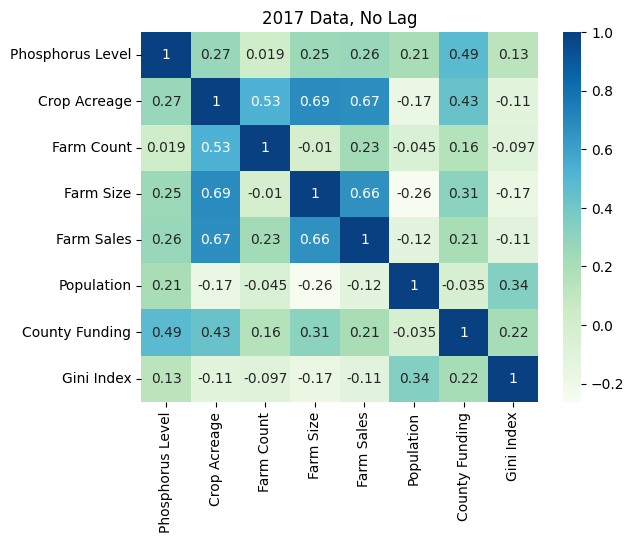

In [184]:
import seaborn as sb
corr = grouped_means.corr()
ax = plt.axes()
sb.heatmap(corr, cmap="GnBu", annot=True, ax = ax)
ax.set_title('2017 Data, No Lag')
plt.savefig('2017corr_updated.png', bbox_inches='tight', pad_inches=0.0)

In [153]:
plt.savefig('corr.png', bbox_inches='tight', pad_inches=0.0)

<Figure size 640x480 with 0 Axes>

# Imputation using KNN

In [53]:
import numpy as np

from sklearn.impute import KNNImputer
X = modeling
imputer = KNNImputer(n_neighbors=2)
imputer.fit_transform(X)

NameError: name 'modeling' is not defined